Chloe Brown, Gauri Dalwankar, Soumya Shikha \
06-625 Final Project \
Project E - Fluid Fluid Reactions \
Coding Section \
December 12, 2022


# **Problem 1**

## Summary of Equations and Degrees of Freedom

List of Equations:

1. $\frac{dP_A}{dh} = \frac{Pt}{F_g/A_c}r$
2. $\frac{dC_A}{dh} = \frac{Ct}{F_l/A_c}r$
3. $r = \frac{p_A - H_AC_A}{\large \frac{H_A}{k_{Al}a} + \frac{1}{k_{Ag}a}}$

Degrees of Freedom Analysis:

Equation | Unknowns (Number) | Number of Equations | DOF | Sum
---------|-------------------|---------------------|-----|----
(1)      | $P_A$, $r$ (2)    | 1                   | 2-1=1 | 1
(2)      | $C_A$ (1)         | 1                   | 1-1=0 | 1
(3)      | $P_A^*$ (1)           | 1                   | 1-1=0 | 1
(4)      | -- (0)            | 1                   | 0-1 = -1| 0

## Code

Since we are given boundary conditions at either end of the pfr, we will use the scipy equation solve_bvp to model this systme.

First, we need to define a function to represent our DAE system. This is the function 'pfr' below. 

We also need to define a function to represent the boundary conditions. This is the function 'bc' below.





In [ ]:
import numpy as np
from scipy.integrate import solve_bvp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# data
kga = 0.32            # mol/hr m^3 Pa
kla = 0.1             # 1/hr
Fg_Acs =  1e5         # mol/hr m^2
Fl_Acs = 7e5          # mol/hr m^2
Pt = 1e5              # Pa
Ct = 56000            # mol/m^3
Ha = 12.5             # Pa m^3/mol
Kag = 0.0078          # mol/hr m^3 Pa
Pa_end = 100          # Pa
Ca_start = 0          # mol/m^3
Pa_desired = 20       # Pa

# define system of ODEs
def pfr(h, X):
  
  # unpack the concentrations
  Pa, Ca = X              # [Pa, mol/m^3]

  # Henry's law
  Pa_star = Ha*Ca         # Pa 

  # define the rate equation
  r = Kag*(Pa-Pa_star)    # mol/m^3 hr

  # differential equations
  dPa = r * (Pt/Fg_Acs)   # Pa/m^3
  dCa = r * (Ct/Fl_Acs)   # (mol/m^3)/m^3

  return np.array([dPa, dCa])

# function for boundary conditions
def bc(Y_start, Y_end):

  # unpack boundary conditions
  Ya_start, Yb_start = Y_start    # [Pa, mol/m^3]
  Ya_end, Yb_end = Y_end          # [Pa, mol/m^3]

  # Pa(bottom) = 100, Ca(top) = 0
  return np.array([Ya_end-Pa_end, Yb_start-Ca_start])


Before we can plot the concentration profiles, we need to know what height the reactor shouold be. 

We will do this by solving the boundary value problem at different heights and plotting what the outlet partial pressure of A is at each height.

In [ ]:
# define a list heights over which to integrate
height_list = np.linspace(1, 600, 1000)    

# save the final partial pressure of A
Pa_list = []                               

# solve boundary value problem at a variety of heights
for i in range(len(height_list)):
  
  # define integration range for solve_bvp
  h = height_list[i]             
  h_span = np.array([0, h])
  h_eval = np.linspace(*h_span, 1000)

  # define initial guesses
  # initial guess for Pa
  Ya_start = 20
  Ya_end = Pa_end
  Ya_m = (Ya_end-Ya_start)/h
  Ya_guess = Ya_m*h_eval + Ya_start

  # initial guess for Ca
  Yb_start = Ca_start
  Yb_end = 0
  Yb_m = (Yb_end-Yb_start)/h
  Yb_guess = Yb_m*h_eval + Yb_start

  Y_guess = np.array([Ya_guess, Yb_guess])

  # solve the bvp
  sol = solve_bvp(pfr, bc, h_eval, Y_guess)
  
  # add the purity of Pa at the top of the reactor to the list
  Pa_list.append(sol.y[0][0])

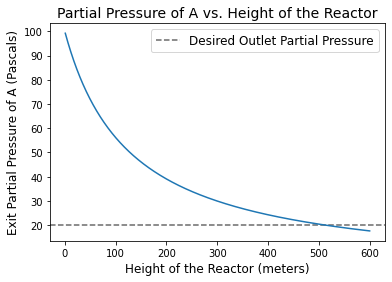

In [ ]:
# plot
plt.axhline(Pa_desired, 0, 600, color = "dimgrey", linestyle = "--", 
            label = "Desired Outlet Partial Pressure");
plt.plot(height_list, Pa_list);
plt.title("Partial Pressure of A vs. Height of the Reactor", fontsize = 14);
plt.xlabel("Height of the Reactor (meters)", fontsize = 12);
plt.ylabel("Exit Partial Pressure of A (Pascals)", fontsize = 12);
plt.legend(fontsize = 12);
#plt.savefig('/content/drive/MyDrive/Chemical and Reactive Systems Project/FIgures/Height1.png', dpi = 300)

Since we now have a list of purities and their respective heights, we can use linear interpolation to find the height for our desired purity. 
In this problem the desired partial pressure of A was 20 Pascals.

In [ ]:
# interpoolator function
def interpolator(x_list, y_list, x_calc):
  for i in range(len(x_list)-1):
    xa = x_list[i]
    xb = x_list[i+1]
    ya = y_list[i]
    yb = y_list[i+1]

    # find closest points to x_calc
    if (xa >= x_calc and xb <= x_calc):

      # interpolate
      y_calc = (yb-ya)/(xb-xa)*(x_calc-xa) + ya
      return y_calc

#  calculate h
h = interpolator(Pa_list, height_list, 20.0)
print(f"The reactor height needed to get a partial pressure of A of {Pa_desired} Pascals is {h:1.2f} meters.")

The reactor height needed to get a partial pressure of A of 20 Pascals is 512.82 meters.


Now, we can solve for the concentration profiles over the whole reactor.

In [ ]:
# define the range over which to integrate
h_span = np.array([0, h])
h_eval = np.linspace(*h_span, 1000)

# define initial guess (linear profile)
# initial guess for Pa
Ya_start = 20
Ya_end = Pa_end
Ya_m = (Ya_end-Ya_start)/h
Ya_guess = Ya_m*h_eval + Ya_start

# initial guess for Cb
Yb_start = Ca_start
Yb_end = 10
Yb_m = (Yb_end-Yb_start)/h
Yb_guess = Yb_m*h_eval + Yb_start

Y_guess = np.array([Ya_guess, Yb_guess])

# solve the boundary value problem
sol = solve_bvp(pfr, bc, h_eval, Y_guess)
sol.message

'The algorithm converged to the desired accuracy.'

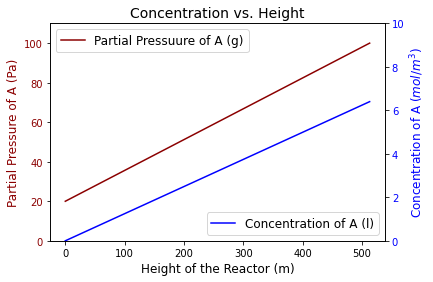

In [ ]:
# plot
fig, ax1 = plt.subplots();
ax2 = ax1.twinx();
plt.title("Concentration vs. Height", fontsize = 14);

ax1.plot(sol.x, sol.y[0], color = "darkred", label = "Partial Pressuure of A (g)");
ax1.set_ylim(bottom = 0, top = 110);
ax1.set_ylabel("Partial Pressure of A (Pa)", fontsize = 12, color = "darkred");
ax1.tick_params(axis ='y', labelcolor = "darkred");
ax1.set_xlabel("Height of the Reactor (m)", fontsize = 12);
ax1.legend(fontsize = 12, loc= "upper left");

ax2.plot(sol.x, sol.y[1], color = "blue", label = "Concentration of A (l)");
ax2.set_ylim(bottom = 0, top = 10);
ax2.set_ylabel("Concentration of A ($mol/m^3$)", fontsize = 12, color = "blue");
ax2.tick_params(axis ='y', labelcolor = "blue");
ax2.legend(fontsize = 12, loc= "lower right");

#plt.savefig('/content/drive/MyDrive/Chemical and Reactive Systems Project/FIgures/Concentrations1.png', dpi = 300)

# **Problem 2**

## Summary of Equations and Degrees of Freedom

List of Equations:

1. $\frac{dP_A}{dh} = \frac{Pt}{F_g/A_c}r$
2. $\frac{dC_B}{dh} = -\frac{Ct}{F_l/A_c}r$
3. $r = k_{Ag}aP_A$

Degrees of Freedom Analysis:

Equation | Unknowns (Number) | Number of Equations | DOF | Sum
---------|-------------------|---------------------|-----|----
(1)      | $P_A$, $r$ (2)    | 1                   | 2-1=1 | 1
(2)      | $C_A$ (1)         | 1                   | 1-1=0 | 1
(3)      | --(0)           | 1                   | 0-1=-1 | 0


## Code

We will solve this problem similar to equation 1. First, we will define functions to represent the boundary value problem. Then, we will use solve_bvp to find the outlet partial pressure of A at varying heights. Next, we will use linear interpolation to find the height of the reactor needed to get the desired purity of A. Finally, we we will plot the concentration profiles of A and B in the reactor. 


In [ ]:
import numpy as np
from scipy.integrate import solve_bvp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# data
kga = 0.32     # mol/hr m^3 Pa
kla = 0.1      # 1/hr
Fg_Acs =  1e5  # mol/hr m^3
Fl_Acs = 7e5   # mol/hr m^3
Pt = 1e5       # Pa
Ct = 56000     # mol/m^3
Pa_end = 100   # Pa
Cb_start = 800 # mol/m^3


# define system of ODEs
def pfr(h, X):
  
  # unpack the concentrations
  Pa, Cb = X

  # define the rate equation
  r = kga*Pa

  # differential equations
  dPa = r * (Pt/Fg_Acs)
  dCb = -1*r * (Ct/Fl_Acs)

  return np.array([dPa, dCb])

# function for boundary conditions
def bc(Y_start, Y_end):

  # unpack boundary conditions
  Ya_start, Yb_start = Y_start
  Ya_end, Yb_end = Y_end

  # Pa(end) = 100, Cb(start) = 800
  return np.array([Ya_end-Pa_end, Yb_start-Cb_start])

In [ ]:
# define a list heights over which to integrate
height_list = np.linspace(1, 30, 1000)    

# save the final partial pressure of A
Pa_list = []                               

# solve boundary value problem at a variety of heights
for i in range(len(height_list)):
  
  # define integration range for solve_bvp
  h = height_list[i]             
  h_span = np.array([0, h])
  h_eval = np.linspace(*h_span, 1000)

  # define initial guesses
  # initial guess for Pa
  Ya_start = 20
  Ya_end = Pa_end
  Ya_m = (Ya_end-Ya_start)/h
  Ya_guess = Ya_m*h_eval + Ya_start

  # initial guess for Ca
  Yb_start = Cb_start
  Yb_end = 0
  Yb_m = (Yb_end-Yb_start)/h
  Yb_guess = Yb_m*h_eval + Yb_start

  Y_guess = np.array([Ya_guess, Yb_guess])

  # solve the bvp
  sol = solve_bvp(pfr, bc, h_eval, Y_guess)
  
  # add the purity of Pa at the top of the reactor to the list
  Pa_list.append(sol.y[0][0])

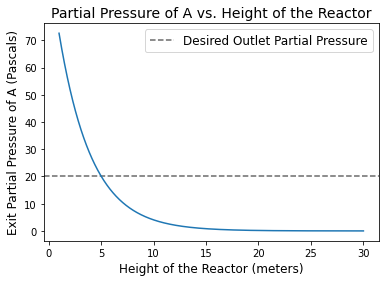

In [ ]:
# plot
plt.axhline(Pa_desired, 0, 30, color = "dimgrey", linestyle = "--", 
            label = "Desired Outlet Partial Pressure");
plt.plot(height_list, Pa_list);
plt.title("Partial Pressure of A vs. Height of the Reactor", fontsize = 14);
plt.xlabel("Height of the Reactor (meters)", fontsize = 12);
plt.ylabel("Exit Partial Pressure of A (Pascals)", fontsize = 12);
plt.legend(fontsize = 12);
#plt.savefig('/content/drive/MyDrive/Chemical and Reactive Systems Project/FIgures/Height2.png', dpi = 300)

In [ ]:
# calculate necessary height
h = interpolator(Pa_list, height_list, 20.0)
print(f"The reactor height needed to get a partial pressure of A of {Pa_desired} Pascals is {h:1.2f} meters.")

The reactor height needed to get a partial pressure of A of 20 Pascals is 5.03 meters.


In [ ]:
# define the range over which to integrate
h_span = np.array([0, h])
h_eval = np.linspace(*h_span, 1000)

# define initial guess (linear profile)
# initial guess for Pa
Ya_start = 20
Ya_end = Pa_end
Ya_m = (Ya_end-Ya_start)/h
Ya_guess = Ya_m*h_eval + Ya_start

# initial guess for Cb
Yb_start = Cb_start
Yb_end = 10
Yb_m = (Yb_end-Yb_start)/h
Yb_guess = Yb_m*h_eval + Yb_start

Y_guess = np.array([Ya_guess, Yb_guess])

# solve the boundary value problem
sol = solve_bvp(pfr, bc, h_eval, Y_guess)
sol.message

'The algorithm converged to the desired accuracy.'

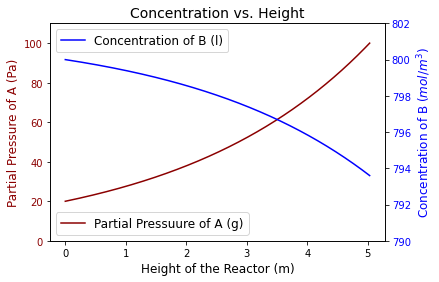

In [ ]:
# plot
fig, ax1 = plt.subplots();
ax2 = ax1.twinx();
plt.title("Concentration vs. Height", fontsize = 14);

ax1.plot(sol.x, sol.y[0], color = "darkred", label = "Partial Pressuure of A (g)");
ax1.set_ylim(bottom = 0, top = 110);
ax1.set_ylabel("Partial Pressure of A (Pa)", fontsize = 12, color = "darkred");
ax1.tick_params(axis ='y', labelcolor = "darkred");
ax1.set_xlabel("Height of the Reactor (m)", fontsize = 12);
ax1.legend(fontsize = 12, loc = "lower left")

ax2.plot(sol.x, sol.y[1], color = "blue", label = "Concentration of B (l)");
ax2.set_ylim(bottom = 790, top = 802);
ax2.set_ylabel("Concentration of B ($mol/m^3$)", fontsize = 12, color = "blue");
ax2.tick_params(axis ='y', labelcolor = "blue");
ax2.legend(fontsize = 12, loc = "upper left")

#plt.savefig('/content/drive/MyDrive/Chemical and Reactive Systems Project/FIgures/Concentrations2.png', dpi = 300)

Finally, we need to confirm that we used the correct rate law.

In [ ]:
# check the top of the rate at the top of the reactor
print(f"Gas film rate (top) = {kga*sol.y[0][0]:1.3f}")
print(f"Liquid film rate (top) = {kla*sol.y[1][0]:1.3f}")

# check the top of the rate at the bottom of the reactor
print(f"Gas film rate (bottom) = {kga*sol.y[0][-1]:1.3f}")
print(f"Liquid film rate (top) = {kla*sol.y[1][-1]:1.3f}")

Gas film rate (top) = 6.400
Liquid film rate (top) = 80.000
Gas film rate (bottom) = 32.000
Liquid film rate (top) = 79.360


# **Problem 3**

## Summary of Equations and Degrees of Freedom

List of Equations:

1. $\frac{dP_A}{dh} = \frac{Pt}{F_g/A_c}r$
2. $\frac{dC_A}{dh} = -\frac{Ct}{F_l/A_c}r$
3. $r = \frac{H_AC_B + P_A}{\frac{1}{k_{Ag}a}+\frac{1}{k_la}}$

Degrees of Freedom Analysis:

Equation | Unknowns (Number) | Number of Equations | DOF | Sum
---------|-------------------|---------------------|-----|----
(1)      | $P_A$, $r$ (2)    | 1                   | 2-1=1 | 1
(2)      | $C_A$ (1)         | 1                   | 1-1=0 | 1
(3)      | --(0)           | 1                   | 0-1=-1 | 0

## Code

We will solve this problem similar to equation 1. First, we will define functions to represent the boundary value problem. Then, we will use solve_bvp to find the outlet partial pressure of A at varying heights. Next, we will use linear interpolation to find the height of the reactor needed to get the desired purity of A. Finally, we we will plot the concentration profiles of A and B in the reactor. 


In [ ]:
import numpy as np
from scipy.integrate import solve_bvp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# data
kga = 0.32       # mol/hr m^3 Pa
kla = 0.1        # 1/hr
Fg_Acs =  1e5    # mol/hr m^2
Fl_Acs = 7e5     # mol/hr m^2
Pt = 1e5         # Pa
Ct = 56000       # mol/m^3
Ha = 12.5        # Pa m^3/mol
Pa_end = 100     # Pa
Cb_start = 32    # mol/m^3

# define system of ODEs
def pfr(h, X):
  
  # unpack the concentrations
  Pa, Cb = X

  # define the rate equation
  r = (Ha*Cb+Pa)/((1/kga)+(Ha/kla))

  # differential equations
  dPa = r * (Pt/Fg_Acs)
  dCb = -1*r * (Ct/Fl_Acs)

  return np.array([dPa, dCb])

# function for boundary conditions
def bc(Y_start, Y_end):

  # unpack boundary conditions
  Ya_start, Yb_start = Y_start
  Ya_end, Yb_end = Y_end

  # Pa(end) = 100, Cb(start) = 32
  return np.array([Ya_end-Pa_end, Yb_start-Cb_start])


In [ ]:
# define a list heights over which to integrate
height_list = np.linspace(1, 30, 1000)    

# save the final partial pressure of A
Pa_list = []                               

# solve boundary value problem at a variety of heights
for i in range(len(height_list)):
  
  # define integration range for solve_bvp
  h = height_list[i]             
  h_span = np.array([0, h])
  h_eval = np.linspace(*h_span, 1000)

  # define initial guesses
  # initial guess for Pa
  Ya_start = 20
  Ya_end = Pa_end
  Ya_m = (Ya_end-Ya_start)/h
  Ya_guess = Ya_m*h_eval + Ya_start

  # initial guess for Ca
  Yb_start = Cb_start
  Yb_end = 0
  Yb_m = (Yb_end-Yb_start)/h
  Yb_guess = Yb_m*h_eval + Yb_start

  Y_guess = np.array([Ya_guess, Yb_guess])

  # solve the bvp
  sol = solve_bvp(pfr, bc, h_eval, Y_guess)
  
  # add the purity of Pa at the top of the reactor to the list
  Pa_list.append(sol.y[0][0])

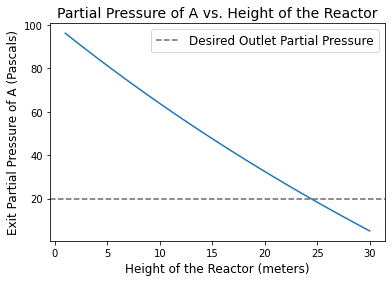

In [ ]:
# plot
plt.axhline(Pa_desired, 0, 30, color = "dimgrey", linestyle = "--", 
            label = "Desired Outlet Partial Pressure");
plt.plot(height_list, Pa_list);
plt.title("Partial Pressure of A vs. Height of the Reactor", fontsize = 14);
plt.xlabel("Height of the Reactor (meters)", fontsize = 12);
plt.ylabel("Exit Partial Pressure of A (Pascals)", fontsize = 12);
plt.legend(fontsize = 12);
#plt.savefig('/content/drive/MyDrive/Chemical and Reactive Systems Project/FIgures/Height3.png', dpi = 300)

In [ ]:
# calculate necessary height
h = interpolator(Pa_list, height_list, 20.0)
print(f"The reactor height needed to get a partial pressure of A of {Pa_desired} Pascals is {h:1.2f} meters.")

The reactor height needed to get a partial pressure of A of 20 Pascals is 24.40 meters.


In [ ]:
# define the range over which to integrate
h_span = np.array([0, h])
h_eval = np.linspace(*h_span, 1000)

# define initial guess (linear profile)
# initial guess for Pa
Ya_start = 20
Ya_end = Pa_end
Ya_m = (Ya_end-Ya_start)/h
Ya_guess = Ya_m*h_eval + Ya_start

# initial guess for Cb
Yb_start = Cb_start
Yb_end = 10
Yb_m = (Yb_end-Yb_start)/h
Yb_guess = Yb_m*h_eval + Yb_start

Y_guess = np.array([Ya_guess, Yb_guess])

# solve the boundary value problem
sol = solve_bvp(pfr, bc, h_eval, Y_guess)
sol.message

'The algorithm converged to the desired accuracy.'

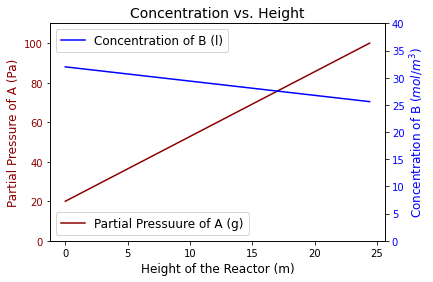

In [ ]:
# plot
fig, ax1 = plt.subplots();
ax2 = ax1.twinx();
plt.title("Concentration vs. Height", fontsize = 14);

ax1.plot(sol.x, sol.y[0], color = "darkred", label = "Partial Pressuure of A (g)");
ax1.set_ylim(bottom = 0, top = 110);
ax1.set_ylabel("Partial Pressure of A (Pa)", fontsize = 12, color = "darkred");
ax1.tick_params(axis ='y', labelcolor = "darkred");
ax1.set_xlabel("Height of the Reactor (m)", fontsize = 12);
ax1.legend(fontsize = 12, loc = "lower left");

ax2.plot(sol.x, sol.y[1], color = "blue", label = "Concentration of B (l)");
ax2.set_ylim(bottom = 0, top = 40);
ax2.set_ylabel("Concentration of B ($mol/m^3$)", fontsize = 12, color = "blue");
ax2.tick_params(axis ='y', labelcolor = "blue");
ax2.legend(fontsize = 12, loc = "upper left")

#plt.savefig('/content/drive/MyDrive/Chemical and Reactive Systems Project/FIgures/Concentrations3.png', dpi = 300)

In [ ]:
# check the top of the rate at the top of the reactor
print(f"Gas film rate (top) = {kga*sol.y[0][0]:1.3f}")
print(f"Liquid film rate (top) = {kla*sol.y[1][0]:1.3f}")

# check the top of the rate at the bottom of the reactor
print(f"Gas film rate (bottom) = {kga*sol.y[0][-1]:1.3f}")
print(f"Liquid film rate (top) = {kla*sol.y[1][-1]:1.3f}")

Gas film rate (top) = 6.400
Liquid film rate (top) = 3.200
Gas film rate (bottom) = 32.000
Liquid film rate (top) = 2.560
